In [201]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import numpy.linalg as la

In [240]:
# Drone properties
# For rotational dynamics, Tait-Bryan ZYX was used
l = .2 # m (length of an arm)
R = .08 # m (radius of rotor)
m = .8 # kg (mass of drone)
g = 9.81 # m/s^2
kt = 1.25*(10**-5) # thrust coefficient for rotors, TBD
km = 1.25*(10**-7) # moment coefficient for rotors, TBD
I = np.diag([.003, .003, .006]) # intertia matrix, update w actual values, TBD

# Define initial conditions for the drone! Does it start with inputs?

# Position (meters)
r_x, r_y, r_z = 2, 0, 1
r = np.array([r_x, r_y, r_z])

# Roll, pitch, yaw angles (radians)
phi, theta, psi = 0, 0, 0
eulers = np.array([phi, theta, psi])

phidot, thetadot, psidot = 0, 0, 0
euler_dot = np.array([phidot, thetadot, psidot])

# Linear velocity (m/s)
v_x, v_y, v_z = 0, 0, 0
v = np.array([v_x, v_y, v_z])

# Angular velocity of drone in body frame (rad/s)
w_x, w_y, w_z = 0, 0, 0
w = np.array([w_x, w_y, w_z])

# Rotor torques
tau_x, tau_y, tau_z = 0, 0, 0
tau = np.array([tau_x, tau_y, tau_z])

# Rotor rotations
w1, w2, w3, w4 = 0, 0, 0, 0
rotors = np.array([w1, w2, w3, w4])

# Translational acceleration and force
a = np.array([0, 0, -g])
f = m*a

# rotation matrix
# from chapter 6 slides, slide 68
def R_zyx(phi, theta, psi):
    #roll, φ, is about x-axis
    #pitch, θ, is about y-axis
    #yaw, ψ, is about z-axis
    roll = np.array([[1, 0, 0],
                     [0, np.cos(phi), -np.sin(phi)],
                     [0, np.sin(phi), np.cos(phi)]])
    pitch = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    yaw = np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])
    return yaw @ pitch @ roll

#useful funcs
# get_euler_rates from chapter 6 slides, slide 68
def get_euler_rates(psi, theta, p, q, r): # finding euler angle rates, general
    coeffs = (1/np.cos(theta)) * np.array([
                        [0, np.sin(psi), np.cos(psi)],
                        [0, np.cos(theta)*np.cos(psi), -np.sin(psi)*np.cos(theta)],
                        [np.cos(theta), np.sin(theta)*np.sin(psi), np.sin(theta)*np.cos(psi)]])
    return coeffs @ np.array([p, q, r])
# get_omegas_body from chapter 6 slides, slide 68
def get_omegas_body(phidot, thetadot, psidot, theta, psi): # finding omegas in body frame (p, q, r), general
    coeffs = np.array([[-np.sin(theta), 0, 1],
                       [np.cos(theta)*np.sin(psi), np.cos(psi), 0],
                       [np.cos(theta)*np.cos(psi), -np.sin(psi), 0]])
    return coeffs @ np.array([phidot,thetadot,psidot])

def get_fam(rotors): # finding forces (in body frame) and moments, general
    w1, w2, w3, w4 = rotors
    #rotor arrangement: 1 @ (l,0,0) is CW, 2 @ (0,l,0) is CCW, 3 @ (-l,0,0) is CW, 4 # (0,-l,0) is CCW
    #so 1+3 control pitch, 2+4 control roll
    T1, T2, T3, T4 = kt * w1**2, kt * w2**2, kt * w3**2, kt * w4**2
    thrust_tot = T1 + T2 + T3 + T4
    
    tau_phi = l * (T2 - T4)
    tau_theta = l * (T3 - T1)
    tau_psi = km * (w1**2 - w2**2 + w3**2 - w4**2)
    return np.array([0,0,thrust_tot]), np.array([tau_phi, tau_theta, tau_psi])

def step(rin, vin, eulersin, win, rotorsin, dt): # returns all necessary parameters (position, velocity, euler angles, body omegas, rotor rotations) after a time step of dt
    T, tau = get_fam(rotorsin)
    
    # rotational
    domega = la.inv(I) @ (tau - np.cross(win, I@win))
    wout = win + dt*domega
    dphi, dtheta, dpsi = get_euler_rates(eulersin[2], eulersin[1], wout[0], wout[1], wout[2])
    eulersout = eulersin + np.array([dphi*dt, dtheta*dt, dpsi*dt])

    # translational
    R = R_zyx(eulersout[0], eulersout[1], eulersout[2])
    fout = R@T - np.array([0,0,m*g])
    aout = fout/m 
    vout = vin + aout*dt 
    rout = rin + vout*dt 

    return rout, vout, aout, fout, eulersout, wout

In [244]:
def circularpath(radius, vtarget, t_tot, ro, vo, ao, fo, eulerso, wo):
    r = ro
    v = vo
    a = ao
    f = fo
    eulers = eulerso
    w = wo
    t = 0
    dt = 1 #how often it updates
    t = 0
    
    omega_target = vtarget/radius
    
    while t < t_tot:
        x_target = radius * np.cos(omega_target*t)
        y_target = radius * np.sin(omega_target*t)

        vx_target = -x_target * omega_target
        vy_target = y_target * omega_target
        #print(x_target, y_target, vx_target, vy_target)
        #yaw_target = np.arctan2(vy_target, vx_target)

        ax_target = -x_target * omega_target**2
        ay_target = -y_target * omega_target**2

        T_target_world = m*np.array([ax_target, ay_target, g])
        
        #finding the z unit vec of the body target orientation in world coords
        z_b_world = T_target_world / la.norm(T_target_world)
        phi_target  = np.arctan2(z_b_world[1], z_b_world[2])
        theta_target = np.arctan2(-z_b_world[0],
                                  np.sqrt(z_b_world[1]**2 + z_b_world[2]**2))
        psi_target = eulers[2] #0
        #print(np.degrees(theta_target))
        euler_target = np.array([phi_target, theta_target, psi_target])
        euler_dot_target = (euler_target - eulers) / dt

        w_body_target = get_omegas_body(euler_dot_target[0], euler_dot_target[1], euler_dot_target[2], eulers[1], eulers[2]) #target or current euler angles?
        #print(w_body_target)
        tau_target = I@((w_body_target - w)/dt) #+ np.cross(w, I@w) # w_current or w_body_target?
        #print(tau_target)

        tau_phi_target, tau_theta_target, tau_psi_target = tau_target[0], tau_target[1], tau_target[2]
        T1, T2, T3, T4 = symbols('T1, T2, T3, T4', real=True)
        eq1 = R*(T2 - T4) - tau_phi_target
        eq2 = R*(T3 - T1) - tau_theta_target
        eq3 = km*(-T1 + T2 - T3 + T4) - tau_psi_target
        T_total = np.clip(la.norm(T_target_world), 0.5*m*g, 2.0*m*g) #clipping still doesnt stop it from blowing up....
        eq4 = T1 + T2 + T3 + T4 - la.norm(T_total)
        soln = solve([eq1, eq2, eq3, eq4], (T1, T2, T3, T4))
        #print(soln)
    
        rotor1 = np.sqrt(max(float(soln[T1]), 0.0)/kt)
        rotor2 = np.sqrt(max(float(soln[T2]), 0.0)/kt)
        rotor3 = np.sqrt(max(float(soln[T3]), 0.0)/kt)
        rotor4 = np.sqrt(max(float(soln[T4]), 0.0)/kt)
        rotors = np.array([rotor1, rotor2, rotor3, rotor4])
        #print(rotors)

        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        print(t, " ... ", r, "r = ", np.sqrt(r[0]**2 + r[1]**2), "v = ", np.sqrt(v[0]**2 + v[1]**2))
        t += dt
def circularpath2(radius, vtarget, t_tot, ro, vo, ao, fo, eulerso, wo):
    r = ro
    v = vo
    a = ao
    f = fo
    eulers = eulerso
    w = wo
    t = 0
    dt = 1 #how often it updates, maybe larger timestep stops it from blowing up
    
    omega_target = vtarget/radius #rotation around the target circle! not body omega rate!!
    
    while t < t_tot:
        x_target = radius * np.cos(omega_target*t)
        y_target = radius * np.sin(omega_target*t)

        vx_target = -x_target * omega_target
        vy_target = y_target * omega_target
        #print(x_target, y_target, vx_target, vy_target)

        ax_target = (vx_target - v[0]) / dt
        ay_target = (vy_target - v[1]) / dt

        T_target_world = m*np.array([ax_target, ay_target, g])

        z_b_world = T_target_world / la.norm(T_target_world) #should be good
        theta_target = np.arctan2(z_b_world[0], z_b_world[2])
        phi_target = np.arctan2(z_b_world[1], z_b_world[2])
        psi_target = 0

        euler_target = np.array([phi_target, theta_target, psi_target])
        euler_dot_target = (euler_target - eulers) / dt
        w_body_target = get_omegas_body(euler_dot_target[0], euler_dot_target[1], euler_dot_target[2], theta_target, psi_target) #target or current euler angles?
        
        tau_target = I@((w_body_target - w)/dt) #+ np.cross(w, I@w) # w_current or w_body_target?
        #print(tau_target)
        tau_phi_target, tau_theta_target, tau_psi_target = tau_target[0], tau_target[1], tau_target[2]
        A = np.array([[kt, kt, kt, kt],
                      [0, R*kt, 0, -R*kt],
                      [-R*kt, 0, R*kt, 0],
                      [km, -km, km, -km]])
        b = np.array([la.norm(T_target_world), tau_phi_target, tau_theta_target, tau_psi_target])
        Ti = np.linalg.solve(A, b)
        print(Ti)

        rotor1 = np.sqrt(Ti[0]/kt)
        rotor2 = np.sqrt(Ti[1]/kt)
        rotor3 = np.sqrt(Ti[2]/kt)
        rotor4 = np.sqrt(Ti[3]/kt)
        rotors = np.array([rotor1, rotor2, rotor3, rotor4])
        print(rotors)
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        print(t, " ... ", r, "r = ", np.sqrt(r[0]**2 + r[1]**2), "v = ", np.sqrt(v[0]**2 + v[1]**2), ", eulers = ", eulers)
        t += dt
circularpath(2, .5, 10, r, v, a, f, eulers, w)

0  ...  [2.31245561e+00 1.18971564e-14 9.95819522e-01] r =  2.312455610599984 v =  0.31245561059998395
1  ...  [-51.25807385  34.1958164   67.42921047] r =  61.61772467125762 v =  63.554350641998894
2  ...  [ 1501500.43408107   608651.15606994 -1356630.44570861] r =  1620172.7634208957 v =  1620207.4214499642
3  ...  [ 5.05054676e+10 -1.19115141e+11 -6.52487981e+10] r =  129380133797.91052 v =  129380108035.83153
4  ...  [ 4.70433595e+15  1.69392336e+15 -9.59614209e+14] r =  5000015303128582.0 v =  5000008140265775.0
5  ...  [-1.36033145e+24 -2.38881952e+24  3.86669497e+23] r =  2.74899260811944e+24 v =  2.748992611919353e+24
6  ...  [ 8.96118187e+37 -2.88650818e+38 -3.84322445e+38] r =  3.0224091846518986e+38 v =  3.02240918465188e+38
7  ...  [ 9.19629568e+64  4.87680047e+64 -3.55907929e+64] r =  1.0409372560106732e+65 v =  1.0409372560106732e+65
8  ...  [-1.03531929e+108  6.77996091e+106 -2.58027014e+108] r =  1.0375368960794698e+108 v =  1.0375368960794698e+108
9  ...  [nan nan nan]

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:1647: RuntimeWarning: overflow encountered in multiply
  multiply(a1, b2, out=cp0)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:1648: RuntimeWarning: overflow encountered in multiply
  tmp = array(a2 * b1)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:1649: RuntimeWarning: invalid value encountered in subtract
  cp0 -= tmp
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:1650: RuntimeWarning: overflow encountered in multiply
  multiply(a2, b0, out=cp1)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:1651: RuntimeWarning: overflow encountered in multiply
  multiply(a0, b2, out=tmp)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:1652: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/numeric.py:1653: RuntimeWarning: overflow encountered in multiply
  multiply

In [40]:
# Task 1. Hover at 1m for 2 mins. Rotors instantaneously start rotating at t = 0.
def hoverforatime(t_tot, ro, vo, ao, fo, eulerso, wo):
    t = 0
    dt = .1

    tovertime = []
    rovertime = []
    vovertime = []
    eulersovertime = []
    powerovertime = []
    rotorovertime = []

    thrust_perrotor = (m * 9.81) / 4
    rotors = np.sqrt(thrust_perrotor / kt), -np.sqrt(thrust_perrotor / kt), np.sqrt(thrust_perrotor / kt), -np.sqrt(thrust_perrotor / kt) # T = k w^2
    power = 4 * np.sqrt(thrust_perrotor**3 / (2*1.225*np.pi*(R**2))) #as given in sources

    while (t <= t_tot):
        ro, vo, ao, fo, eulerso, wo = step(r, v, eulers, w, rotors, dt)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        print(r[2], dt)
        t += dt
    return tovertime, rovertime, vovertime, eulersovertime

#t_t, r_t, v_t, eulers_t = hoverforatime(120, r, v, a, f, eulers, w)

In [ ]:
plt.style.use('_mpl-gallery')
r_tx = np.array(r_t).T[0]
r_ty = np.array(r_t).T[1]
r_tz = np.array(r_t).T[2]

v_tx = np.array(v_t).T[0]
v_ty = np.array(v_t).T[1]
v_tz = np.array(v_t).T[2]

phi_t = np.rad2deg(np.array(eulers_t).T[0])
theta_t = np.rad2deg(np.array(eulers_t).T[1])
psi_t = np.rad2deg(np.array(eulers_t).T[2])

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 6), layout="constrained")
axs[0][0].plot(t_t, r_tx, 'r-')
axs[0][0].set_title('Drone X Position Over Time in Task 1', )
axs[0][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('X Coordinate (m)')

axs[0][1].plot(t_t, r_ty, 'g-')
axs[0][1].set_title('Drone Y Position Over Time in Task 1')
axs[0][1].set_xlabel('Time (s)')
axs[0][1].set_ylabel('Y Coordinate (m)')

axs[0][2].plot(t_t, r_tz, 'b-')
axs[0][2].set_title('Drone Z Position Over Time in Task 1')
axs[0][2].set_xlabel('Time (s)')
axs[0][2].set_ylabel('Z Coordinate (m)')

axs[1][0].plot(t_t, v_tx, 'c-')
axs[1][0].set_title('Drone X Velocity Over Time in Task 1', )
axs[1][0].set_xlabel('Time (s)')
axs[1][0].set_ylabel('X Velocity (m/s)')

axs[1][1].plot(t_t, v_ty, 'm-')
axs[1][1].set_title('Drone Y Velocity Over Time in Task 1')
axs[1][1].set_xlabel('Time (s)')
axs[1][1].set_ylabel('Y Velocity (m/s)')

axs[1][2].plot(t_t, v_tz, 'y-')
axs[1][2].set_title('Drone Z Velocity Over Time in Task 1')
axs[1][2].set_xlabel('Time (s)')
axs[1][2].set_ylabel('Z Velocity (m/s)')

axs[2][0].plot(t_t, phi_t, 'k-')
axs[2][0].set_title('Drone Yaw Angle Over Time in Task 1', )
axs[2][0].set_xlabel('Time (s)')
axs[2][0].set_ylabel('Yaw Angle (degrees)')

axs[2][1].plot(t_t, theta_t, color = 'mediumslateblue', linestyle = '-')
axs[2][1].set_title('Drone Pitch Angle Over Time in Task 1')
axs[2][1].set_xlabel('Time (s)')
axs[2][1].set_ylabel('Pitch Angle (degrees)')

axs[2][2].plot(t_t, psi_t, color = 'pink', linestyle = '-')
axs[2][2].set_title('Drone Roll Angle Over Time in Task 1')
axs[2][2].set_xlabel('Time (s)')
axs[2][2].set_ylabel('Roll Angle (degrees)')

In [73]:
# Task 3. Launch from ground and ascend vertically until 1m above ground. Move in a straight line 1m above ground at an average speed of 1m/s for 5m,
# stop (hover), yaw 90 deg to the left, move in another straight line for 5m, stop (hover), land vertically with a speed of no more than 1cm/s.
def task3(h_tot, ro, vo, ao, fo, eulerso, wo):
    t = 0
    dt = .01 #how often it updates
    r = ro
    v = vo
    a = ao
    f = fo
    eulers = eulerso
    w = wo

    tovertime = []
    rovertime = []
    vovertime = []
    eulersovertime = []
    powerovertime = []
    rotorovertime = []

    # initial rotor speed update
    thrust_perrotor = .01 + ((m * 9.81) / 4)
    rotors = np.array([np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt), np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt)]) # T = k w^2
    power = 4 * np.sqrt(thrust_perrotor**3 / (2*1.225*np.pi*(R**2)))

    # STEP 1: Launch from ground and ascend vertically until 1m above ground. Will slow when close to target height
    while (r[2] < h_tot):
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)

        if r[2] >= .975*h_tot:
            # update rotor speeds
            thrust_perrotor = 1.0001*((m * 9.81) / 4)
            rotors = np.array([np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt), np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt)])
        if r[2] >= .99*h_tot:
            # update rotor speeds
            thrust_perrotor = 1.00001*((m * 9.81) / 4)
            rotors = np.array([np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt), np.sqrt(thrust_perrotor/kt), -np.sqrt(thrust_perrotor/kt)])
        if r[2] > .9995*h_tot:
            break
        t += dt
    print(r[2], t)

    # Step 1 done, return to hover rotor speeds before start step 2!!

    az_target = -v[2]/(10*dt)
    thrust_target = np.array([0,0,(m*(g+az_target))])
    thrust_needed = la.inv(R_zyx(eulers[0],eulers[1],eulers[2])) @ thrust_target
    print("thrust needed is ", thrust_needed)
    for i in range(10):
        rotors = np.array([np.sqrt(.25*thrust_needed[2] /kt), -np.sqrt(.25*thrust_needed[2] /kt), np.sqrt(.25*thrust_needed[2] /kt), -np.sqrt(.25*thrust_needed[2] /kt)])
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        t += dt

    for i in range(10):
        thrust_perrotor_hover = ((m * 9.81) / 4)
        rotors = np.array([np.sqrt(thrust_perrotor_hover/kt), -np.sqrt(thrust_perrotor_hover/kt), np.sqrt(thrust_perrotor_hover/kt), -np.sqrt(thrust_perrotor_hover/kt)])
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        t += dt
        print(r[2], v[2], a[2], t)

    # STEP 2: Move in a straight line 1m above ground at an average speed of 1m/s for 5m
    # need to fix from this point on
    ax_target = 1/(2*5) #2d kinematics for an acceleration target estimate
    thrust_target = np.array([ax_target,0,m*g])
    thrust_needed = la.inv(R_zyx(eulers[0],eulers[1],eulers[2])) @ thrust_target
    print("thrust needed is ", thrust_needed)

    #theta_target = np.arcsin(ax_target/g)
    #thrustdiff_perpair = ((np.tan(theta_target) * m * 9.81))
    T1 = thrust_needed[2]/4 + thrust_needed[0]/2
    T2 = thrust_needed[2]/4
    T3 = thrust_needed[2]/4 - thrust_needed[0]/2
    T4 = thrust_needed[2]/4
    rotors[0] = np.sqrt(T1/kt)
    rotors[1] = np.sqrt(T2/kt)
    rotors[2] = -np.sqrt(T3/kt)
    rotors[3] = -np.sqrt(T4/kt)
    tmark = t
    # continue at that rotor speed we just found that puts us at a velocity of 
    while (t <= tmark + 1):
        r, v, a, f, eulers, w = step(r, v, eulers, w, rotors, dt)
        tovertime.append(t)
        rovertime.append(r)
        vovertime.append(v)
        eulersovertime.append(eulers)
        powerovertime.append(power)
        rotorovertime.append(rotors)
        print(r, v, t)
        t += dt

    return tovertime, rovertime, vovertime, eulersovertime, powerovertime, rotorovertime

t_t, r_t, v_t, eulers_t, _, _ = task3(1, r, v, a, f, eulers, w)

1.0008256027498899 9.989999999999831
thrust needed is  [ 0.         0.        15.6703323]
1.009712355074889 -1.249000902703301e-16 0.0 10.09999999999983
1.009712355074889 -1.249000902703301e-16 0.0 10.109999999999829
1.009712355074889 -1.249000902703301e-16 0.0 10.119999999999829
1.009712355074889 -1.249000902703301e-16 0.0 10.129999999999828
1.009712355074889 -1.249000902703301e-16 0.0 10.139999999999828
1.009712355074889 -1.249000902703301e-16 0.0 10.149999999999828
1.009712355074889 -1.249000902703301e-16 0.0 10.159999999999828
1.009712355074889 -1.249000902703301e-16 0.0 10.169999999999828
1.009712355074889 -1.249000902703301e-16 0.0 10.179999999999827
1.009712355074889 -1.249000902703301e-16 0.0 10.189999999999827
thrust needed is  [ 0.1   0.   19.62]
[0.         0.         1.00971236] [ 0.0000000e+00  0.0000000e+00 -1.2490009e-16] 10.189999999999827
[9.80999998e-08 0.00000000e+00 1.00971236e+00] [ 9.80999998e-06  0.00000000e+00 -4.90500121e-10] 10.199999999999827
[4.90499995e-07 

Text(0, 0.5, 'Roll Angle (degrees)')

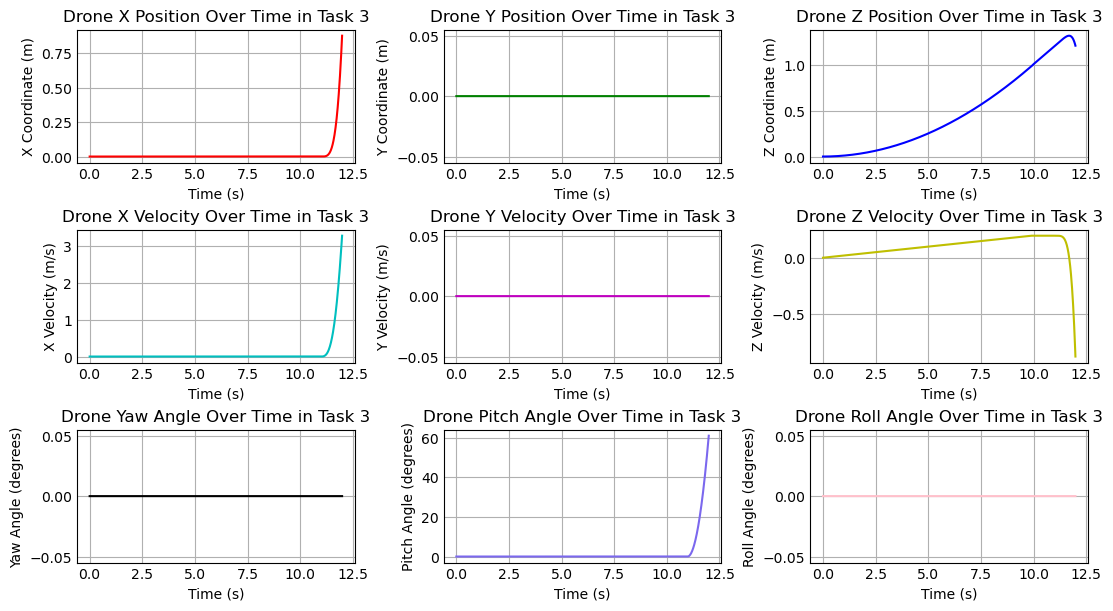

In [46]:
plt.style.use('_mpl-gallery')
r_tx = np.array(r_t).T[0]
r_ty = np.array(r_t).T[1]
r_tz = np.array(r_t).T[2]

v_tx = np.array(v_t).T[0]
v_ty = np.array(v_t).T[1]
v_tz = np.array(v_t).T[2]

phi_t = np.rad2deg(np.array(eulers_t).T[0])
theta_t = np.rad2deg(np.array(eulers_t).T[1])
psi_t = np.rad2deg(np.array(eulers_t).T[2])

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 6), layout="constrained")
axs[0][0].plot(t_t, r_tx, 'r-')
axs[0][0].set_title('Drone X Position Over Time in Task 3', )
axs[0][0].set_xlabel('Time (s)')
axs[0][0].set_ylabel('X Coordinate (m)')

axs[0][1].plot(t_t, r_ty, 'g-')
axs[0][1].set_title('Drone Y Position Over Time in Task 3')
axs[0][1].set_xlabel('Time (s)')
axs[0][1].set_ylabel('Y Coordinate (m)')

axs[0][2].plot(t_t, r_tz, 'b-')
axs[0][2].set_title('Drone Z Position Over Time in Task 3')
axs[0][2].set_xlabel('Time (s)')
axs[0][2].set_ylabel('Z Coordinate (m)')

axs[1][0].plot(t_t, v_tx, 'c-')
axs[1][0].set_title('Drone X Velocity Over Time in Task 3', )
axs[1][0].set_xlabel('Time (s)')
axs[1][0].set_ylabel('X Velocity (m/s)')

axs[1][1].plot(t_t, v_ty, 'm-')
axs[1][1].set_title('Drone Y Velocity Over Time in Task 3')
axs[1][1].set_xlabel('Time (s)')
axs[1][1].set_ylabel('Y Velocity (m/s)')

axs[1][2].plot(t_t, v_tz, 'y-')
axs[1][2].set_title('Drone Z Velocity Over Time in Task 3')
axs[1][2].set_xlabel('Time (s)')
axs[1][2].set_ylabel('Z Velocity (m/s)')

axs[2][0].plot(t_t, phi_t, 'k-')
axs[2][0].set_title('Drone Yaw Angle Over Time in Task 3', )
axs[2][0].set_xlabel('Time (s)')
axs[2][0].set_ylabel('Yaw Angle (degrees)')

axs[2][1].plot(t_t, theta_t, color = 'mediumslateblue', linestyle = '-')
axs[2][1].set_title('Drone Pitch Angle Over Time in Task 3')
axs[2][1].set_xlabel('Time (s)')
axs[2][1].set_ylabel('Pitch Angle (degrees)')

axs[2][2].plot(t_t, psi_t, color = 'pink', linestyle = '-')
axs[2][2].set_title('Drone Roll Angle Over Time in Task 3')
axs[2][2].set_xlabel('Time (s)')
axs[2][2].set_ylabel('Roll Angle (degrees)')

In [ ]:
#old
def task_1 (t_tot, r, eulers, v, a, f, w_rotors):
    t = 0
    dt = 1
    
    
    # Update EOM... is this sufficient

    thrust = (m * 9.81) / 4 # Hard code
    w_rotors = np.sqrt(thrust), -np.sqrt(thrust), np.sqrt(thrust), -np.sqrt(thrust) # T = k w^2
    f = f + np.array([0, 0, 4*thrust])

    # While loop to accomplish task 1. in this case we are flying for time, could change to loop with position. equations would update. this is basic case

    while (t < t_tot):
        t += dt
        a = f/m
        v = v + a*dt
        r = r + v*dt

        print(a[2], v[2], r[2]) #print for now, can create an array (keep track parallel to a time array) so that we can easily generate graphs later on

    P_task_1 = 4 * np.sqrt(thrust**3 / (2*1.225*np.pi*(R**2))) #as given in sources
    return P_task_1
#task_1(5, r, eulers, v, a, f, rotors)
        

In [ ]:
#old
def rise (h_tot, r, eulers, v, a, f, w_rotors):
    h = 0
    #dh = 10
    t = 0
    dt = .1
    # Update EOM... is this sufficient

    thrust = (1.1 * m * 9.81) / 4 # Hard code
    w_rotors = np.sqrt(thrust), -np.sqrt(thrust), np.sqrt(thrust), -np.sqrt(thrust) # T = k w^2
    f = f + np.array([0, 0, 4*thrust])

    # While loop to accomplish task 1. in this case we are flying for time, could change to loop with position. equations would update. this is basic case

    while (h < h_tot):
        t += dt
        a = f/m
        v = v + a*dt
        rz = r[2]
        r = r + v*dt
        h += r[2] - rz
        print(a[2], v[2], r[2]) #print for now, can create an array (keep track parallel to a time array) so that we can easily generate graphs later on
    P_task_1 = 4 * np.sqrt(thrust**3 / (2*1.225*np.pi*(R**2))) #as given in sources
    # update rotors to be at hover speed
    return P_task_1
#rise (.1, r, eulers, v, a, f, rotors)